# Dog Breed Prediction using Trasnfer Learing on SageMaker 

This notebook contains code for running a hyperparameter tuning job for a PyTorch model. This will help in determining the best hyperparameters to us for the final or actual model. This model will also be deployed as an endpoint and used for inference. There will also be a profiler report generated with mode detailed information on the model and the environment on which it was being trained on.

In [1]:
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs, 
    DebuggerHookConfig, ProfilerConfig, FrameworkProfile,
)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [3]:
print("Default Bucket: {}".format(bucket))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-420657680415
RoleArn: arn:aws:iam::420657680415:role/service-role/AmazonSageMaker-ExecutionRole-20211214T182879


## Dataset

The dataset we used for this project is the dogImages dataset that can be fould in this [link](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). It contains images of 133 dog breed split into train, valid and test folders each containing a sample of every breed. An example from the train folder s is `./dogImages/test/018.Beauceron/Beauceron_01284.jpg`

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
# Uploading the data to an S3 bucket
local_dir = 'dogImages'
prefix = "image_classification_project"
inputs = sagemaker_session.upload_data(path=local_dir, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

In [4]:
# Saving this to avoid uploading the inputs again)
inputs = "s3://sagemaker-us-east-1-420657680415/image_classification_project"
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-420657680415/image_classification_project


## Hyperparameter Tuning


In [5]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(5, 10),
    "momentum": ContinuousParameter(0.5, 0.9), # Adding this since SDG is the optimization function chosen
}

In [6]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

In [7]:
# Estimator for your Hyperparameter tuning jobs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

# Tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)

In [ ]:
# Fit your Hyperparameter Tuner with data channels included
tuner.fit({"training": inputs}, wait=True)

..........................................................................

In [10]:
# Get the best estimators with the best Hyperparameters
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-06 21:10:11 Starting - Preparing the instances for training
2022-01-06 21:10:11 Downloading - Downloading input data
2022-01-06 21:10:11 Training - Training image download completed. Training in progress.
2022-01-06 21:10:11 Uploading - Uploading generated training model
2022-01-06 21:10:11 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '5',
 'lr': '0.08664879920891638',
 'momentum': '0.8566271802090872',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-06-20-28-19-429"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-420657680415/pytorch-training-2022-01-06-20-28-19-429/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

Using the best hyperparameters, create and finetune a new model or the actual model using the `train_model.py` script to perform model profiling and debugging.

In [11]:
best_hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()["batch-size"].replace('"', "")),
    "epochs": best_estimator.hyperparameters()["epochs"],
    "lr": best_estimator.hyperparameters()["lr"],
    "momentum": best_estimator.hyperparameters()["momentum"],
}

In [12]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [13]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    framework_version="1.6", # using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=best_hyperparameters,
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
)

In [14]:
estimator.fit({"training": inputs}, wait=True)

2022-01-07 05:08:02 Starting - Starting the training job...
2022-01-07 05:08:32 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-07 05:09:27 Starting - Preparing the instances for training.........
2022-01-07 05:10:53 Downloading - Downloading input data............
2022-01-07 05:12:55 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-07 05:12:55,826 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-07 05:12:55,860 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-07 05:12:57,285 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-07 05:13:04,928 sagemaker-training-toolkit INFO  

In [15]:
# Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-01-07-05-08-01-251
Region: us-east-1


In [16]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

[2022-01-07 05:27:40.351 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:316 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-420657680415/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-420657680415/pytorch-training-2022-01-07-05-08-01-251/profiler-output


Profiler data from system is available


In [17]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-01-07 05:28:00.450 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:316 INFO metrics_reader_base.py:134] Getting 16 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


There was no anomalous behaviour in the plots above, but the activity would have been anomalous if the spikes for GPU utilization was zero and CPU utilization was very high. This would mean that I was not training on GPU even though I had specified that I should be uing a GPU for training.

In [18]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-420657680415/pytorch-training-2022-01-07-05-08-01-251/rule-output


In [19]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-01-07 05:25:51     406934 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-07 05:25:51     260630 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-07 05:25:46        192 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-07 05:25:46      34734 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-07 05:25:46        126 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-07 05:25:46        328 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-07 05:25:46       4379 pytorch-training-2022-01-07-05-08-01-251/rule-output/ProfilerReport/profiler-output/profiler-re

In [20]:
# Display the profiler output
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

The profiler failed to generate plots. This was a blocker I could fix regardless of help from Knowledge and Peer Chat.

In [21]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# Deploy your model to an endpoint
# This method of deployment was buggy so I opted for the one below.
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

In [22]:
from sagemaker.pytorch import PyTorchModel

In [23]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-420657680415/pytorch-training-2022-01-07-05-08-01-251/output/model.tar.gz


In [24]:
# Implemented the inference.py file which loads and invokes the trained model above.
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8"
)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-------------!

In [25]:
# installing these as they'll be needed for inference
!pip3 install torch torchvision --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 881.9 MB 99.8 MB/s             
     |████████████████████████████████| 23.3 MB 66.9 MB/s            


In [26]:
# Run an prediction on the endpoint
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [27]:
# This predict fnction takes in an image, preprocesses it, and uses the endpoint for prediction
def predict(image_path):
    image = Image.open(image_path)

    transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    preprocessed_image = transform(image).unsqueeze(0)
    preprocessed_image = preprocessed_image.to("cpu")

    response = predictor.predict(preprocessed_image)
    pred = np.argmax(response, 1)+1
    plt.imshow(Image.open(image_path))
    plt.show()
    print(f"Actual: {int(image_path[17:20])}, Prediction: {pred[0]}")

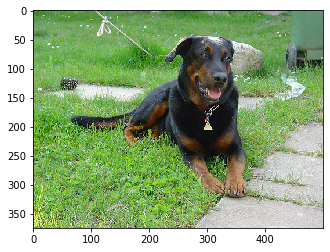

Actual: 18, Prediction: 102



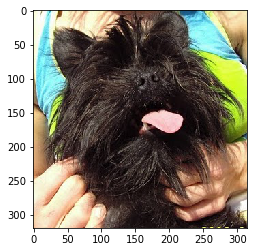

Actual: 1, Prediction: 127



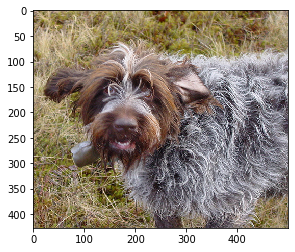

Actual: 131, Prediction: 127



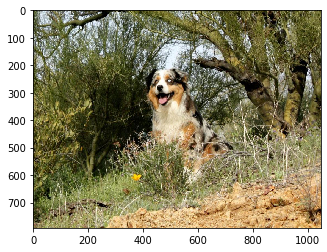

Actual: 12, Prediction: 126



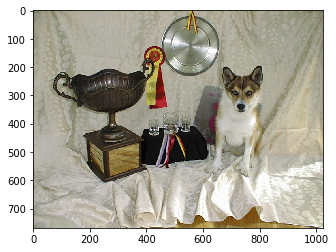

Actual: 110, Prediction: 124



In [28]:
# Images for testing
image_paths = ["./dogImages/test/018.Beauceron/Beauceron_01284.jpg", "./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", 
               "./dogImages/test/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08245.jpg", 
               "./dogImages/test/012.Australian_shepherd/Australian_shepherd_00830.jpg", "./dogImages/test/110.Norwegian_lundehund/Norwegian_lundehund_07222.jpg"]

for path in image_paths:
    predict(path)
    print()

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()